In [283]:
import pandas as pd
import os
from os import getcwd, path
from global_modules import GlobalOperations, Sqlite_v2
go = GlobalOperations()

import matplotlib.pyplot as plt
from datetime import datetime as dtime
from datetime import timedelta as tdelta

def mv_db_df(con):
    r = []
    n = []
    cur = con.cursor()
    cur.execute("select name from sqlite_master where type='table'")
    for t, *_ in cur.fetchall():
        f = pd.read_sql(f"select * from {t}", con)
        # f = pd.read_sql(f"WITH CTE AS (SELECT TOP 1000 * FROM {t} ORDER BY timestamp DESC) SELECT * FROM CTE ORDER BY timestamp", con)
        f['timestamp'] = f.timestamp.astype('float')
        f['timestamp'] = f.timestamp.map(lambda x: dtime.fromtimestamp(int(x)))
        f['value'] = f.value.astype('int64')
        r.append(f)
        n.append(t)
    return n, r

In [284]:
R = getcwd()
DB_P = path.join(R, 'db')
MV_DB_P = path.join(DB_P, go.config['MOVEMENT_SIGNAL_DB'])
N_DB_P = path.join(DB_P, go.config['NOTIFICATIONS_DB'])

mv_db_sql = Sqlite_v2()
n_db_sql = Sqlite_v2()
mv_db_sql.create_connection(MV_DB_P)
n_db_sql.create_connection(N_DB_P)

ts_mv, dbs_mv = mv_db_df(mv_db_sql.conn)
# dbs_n = db_df(n_db_sql.conn)

In [285]:
ts_mv

['outer_fence', 'hallway', 'garden']

In [286]:
dbs_mv[0]

,timestamp,value
0,2023-12-08 18:05:02,0
1,2023-12-08 18:05:03,0
2,2023-12-08 18:05:04,0
3,2023-12-08 18:05:05,0
4,2023-12-08 18:05:06,0
...,...,...
715158,2023-12-19 11:28:08,0
715159,2023-12-19 11:28:09,0
715160,2023-12-19 11:28:10,0
715161,2023-12-19 11:28:11,0


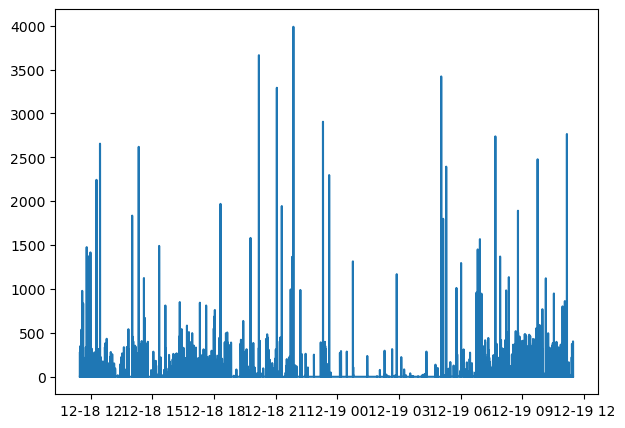

In [287]:
filt = df_mv_of[df_mv_of['timestamp'] > (df_mv_of.tail(1).timestamp - tdelta(days=1)).values[0]]

plt.figure(figsize=(7,5))
plt.plot(filt.timestamp, filt.value)

In [273]:
filt.timestamp.dt.hour

637746    11
637747    11
637748    11
637749    11
637750    11
          ..
715158    11
715159    11
715160    11
715161    11
715162    11
Name: timestamp, Length: 77417, dtype: int32

In [17]:
cur = mv_db_sql.conn.cursor()
cur.execute("select name from sqlite_master where type='table'")
print(cur.fetchall())

cur_n = n_db_sql.conn.cursor()
cur_n.execute("select name from sqlite_master where type='table'")
print(cur_n.fetchall())

[('outer_fence',), ('hallway',), ('garden',)]


[('notifications',)]


In [254]:
def db_df(con):
    r = []
    cur = mv_db_sql.conn.cursor()
    cur.execute("select name from sqlite_master where type='table'")
    for t, *_ in cur.fetchall():
        f = pd.read_sql(f"select * from {t}", con)
        f['timestamp'] = f.timestamp.astype('float')
        f['timestamp'] = f.timestamp.map(lambda x: dtime.fromtimestamp(int(x)))
        f['value'] = f.value.astype('int64')
        r.append(f)
    return r

In [203]:
df_mv_of = pd.read_sql('select * from outer_fence', mv_db_sql.conn)
df_mv_of['timestamp'] = df_mv_of.timestamp.astype('float')
df_mv_of['timestamp'] = df_mv_of.timestamp.map(lambda x: dtime.fromtimestamp(int(x)))
df_mv_of['value'] = df_mv_of.value.astype('int64')

In [204]:
df_mv_of.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715163 entries, 0 to 715162
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  715163 non-null  datetime64[ns]
 1   value      715163 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 10.9 MB


In [41]:
df_mv_of = df_mv_of[df_mv_of['value'] > 0]

In [42]:
df_mv_of.describe().T

,count,mean,std,min,25%,50%,75%,max
timestamp,13877.0,1.702546e+09,282013.585341,1.702034e+09,1.702339e+09,1.702549e+09,1.702810e+09,1.702960e+09
value,13877.0,8.747654e+01,178.021848,1.000000e+00,1.100000e+01,3.100000e+01,9.800000e+01,3.988000e+03


<Axes: >

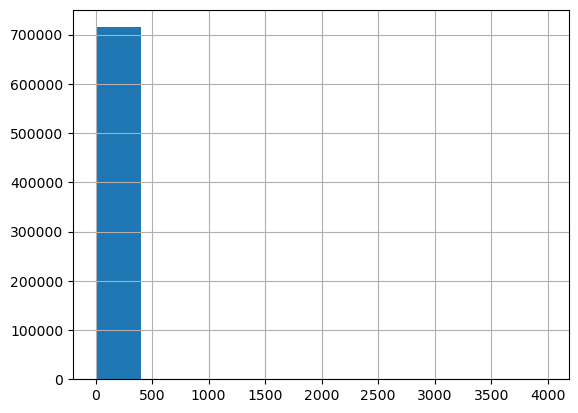

In [159]:
df_mv_of.value.hist()

In [160]:
df_mv_of.timestamp

0         1.702034e+09
1         1.702034e+09
2         1.702034e+09
3         1.702034e+09
4         1.702034e+09
              ...     
715158    1.702960e+09
715159    1.702960e+09
715160    1.702960e+09
715161    1.702960e+09
715162    1.702960e+09
Name: timestamp, Length: 715163, dtype: float64

<Axes: >

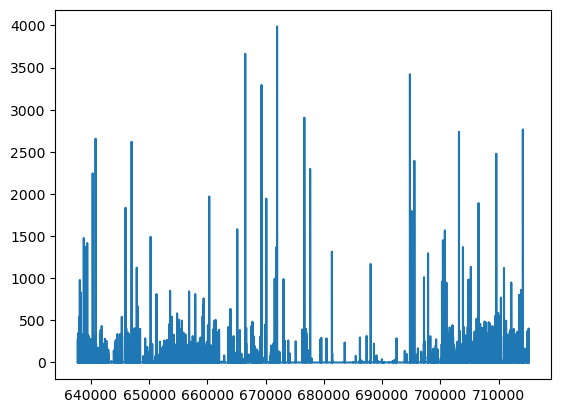

In [253]:
# last_day = df_mv_of.tail()

df_mv_of[df_mv_of['timestamp'] > (df_mv_of.tail(1).timestamp - tdelta(days=1)).values[0]].value.plot()

In [244]:
(df_mv_of.tail(1).timestamp - tdelta(days=1))

715162   2023-12-19 11:28:12
Name: timestamp, dtype: datetime64[ns]

In [250]:
(df_mv_of.tail(1).timestamp - tdelta(days=1)).values[0]

numpy.datetime64('2023-12-18T11:28:12.000000000')

## Algo flow
1. Create a detection bracket (the initial & last index with a specified minimum length)
    - Important to separate outlier with an actual object that continuously moving over a specific time in that frame
2. Preparing for ML input
    - hour & min of the init. MM norm
    - length
    - max, avg, median, MM norm
    - stdev, kurtosis

In [217]:
def detection_bracket(df, min_length=5):
    '''
    df: pd DataFrame with:
        - sequential-asc-sorted index
        - `value` column that hold the detected value
    min_length: a required length to be considered
        as a notable events
    '''
    g = []
    pv = 0
    for i, r in df.iterrows():
        # register the initial bracket
        if r['value'] > 0 and pv == 0:
            ix = i
            ih = r['timestamp'].hour / 60
            im = r['timestamp'].minute / 60
            pv = r['value']
    
        # register the end bracket
        if r['value'] == 0 and pv > 0:
            if i - ix > min_length:
                d = (df[ix:i].describe().value / 
                        df[ix:i].value.max()).tolist()
                d.append(df[ix:i].value.skew())
                d.append(df[ix:i].value.kurtosis())
                d.append(ih)
                d.append(im)
                g.append(d)
            # reset values
            pv = 0
            ih = 0
            im = 0
    return g

In [218]:
det = detection_bracket(df_mv_of)

In [233]:
df_det = pd.DataFrame(det)

In [229]:
i

0

In [230]:
df_det.corr().mean()

0     0.246687
1     0.205734
2     0.199739
3     0.268627
4     0.233005
5     0.174947
6          NaN
7     0.030542
8    -0.206665
9    -0.177544
10   -0.071850
11   -0.031593
dtype: float64

In [232]:
df_det.corr().mean()

0     0.137107
1     0.240539
2     0.198382
3     0.223786
4     0.231682
5     0.205282
6          NaN
7    -0.064353
8    -0.195740
9    -0.137680
10   -0.013086
11    0.079195
dtype: float64

In [234]:
df_det.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.067961,0.474341,0.038835,0.179612,0.563107,0.679612,1.0,0.354399,0.090693,-1.221652,0.300000,0.300000
1,0.011628,0.309432,0.013566,0.055233,0.218023,0.359012,1.0,0.368100,1.662599,2.993818,0.300000,0.316667
2,0.011257,0.491245,0.001876,0.078799,0.503752,0.876642,1.0,0.449781,-0.038814,-2.421954,0.300000,0.316667
3,0.025806,0.190323,0.012903,0.045968,0.059677,0.146774,1.0,0.331153,2.697177,7.425112,0.300000,0.533333
4,0.022039,0.292355,0.019284,0.086088,0.144628,0.378099,1.0,0.341948,1.567341,1.926845,0.316667,0.133333


In [85]:
df_n = pd.read_sql('select * from notifications', n_db_sql.conn)

In [86]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21707 entries, 0 to 21706
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     21707 non-null  object
 1   sha256        21707 non-null  object
 2   flag          21707 non-null  object
 3   triggered_by  21707 non-null  object
dtypes: object(4)
memory usage: 678.5+ KB


In [87]:
df_n['timestamp'] = df_n['timestamp'].astype('float')
df_n['timestamp'] = df_n.timestamp.map(lambda x: dtime.fromtimestamp(int(x)))

In [94]:
df_n.sample(10)

,timestamp,sha256,flag,triggered_by
17421,2023-12-17 11:40:33,b4304da4fb6fda441583c6a0c68c059409801a3a0c674b...,0,outer_fence
1049,2023-12-09 04:52:41,686fb0c94f9425bb65dc1e44dfe6ba1c59ad324fe87a8f...,0,hallway
800,2023-12-08 22:17:21,86881e202633e06c359beae88e337f1340f4b0f80e4ab6...,0,outer_fence
11064,2023-12-14 14:27:02,7ce1b52d3585c5603e715433fd834f23b9653d4fe10e37...,0,outer_fence
643,2023-12-08 20:50:42,df3cd26732719d1c165b8fd6aa2fc6f98c670fc651db8c...,0,outer_fence
489,2023-12-08 20:11:10,9b20306edb071cc2a29ab56954447d30d2194153d7cf53...,0,garden
6294,2023-12-12 11:07:54,df98739db60332f20640e868e09c62812635200c20b41b...,0,outer_fence
6449,2023-12-11 12:47:10,8a40ff51bfde10709955f6f8bf74a0d56154a2ded3f51f...,0,hallway
3172,2023-12-10 09:42:24,922e28c292e0a5a63d7441c681a7eed70dd18a42373cc4...,0,hallway
1894,2023-12-09 10:27:25,67c109423ed21fd1c012f8285f0efc8856a97bfa5cbdee...,0,garden


In [92]:
df_n.groupby('triggered_by').count()

,timestamp,sha256,flag
triggered_by,,,
garden,3826,3826,3826
hallway,9266,9266,9266
outer_fence,8615,8615,8615


In [95]:
df_n.describe()

,timestamp
count,21707
mean,2023-12-14 06:58:09.519371776
min,2023-12-08 18:09:48
25%,2023-12-11 13:12:29.500000
50%,2023-12-14 12:43:04
75%,2023-12-16 22:41:31.500000
max,2023-12-19 11:15:38


<Axes: xlabel='timestamp'>

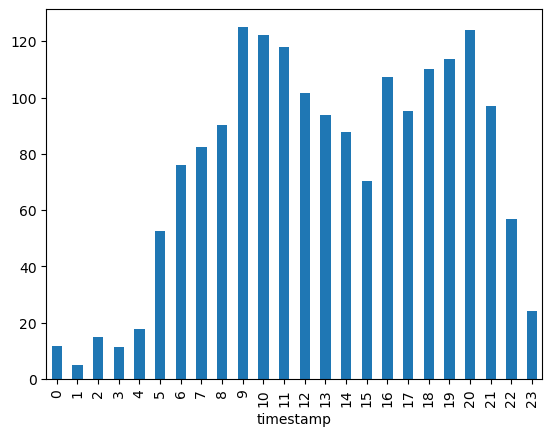

In [130]:
((df_n.groupby(df_n.timestamp.dt.hour).count())/ len(df_n.timestamp.dt.date.unique()))['timestamp'].plot.bar(legend=False)

<Axes: xlabel='timestamp'>

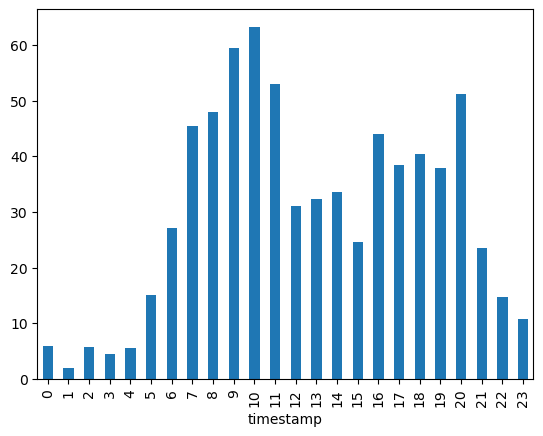

In [131]:
df_n_of = df_n[df_n['triggered_by'] == 'outer_fence']

((df_n_of.groupby(df_n_of.timestamp.dt.hour).count())/ len(df_n_of.timestamp.dt.date.unique()))['timestamp'].plot.bar(legend=False)

<Axes: xlabel='timestamp'>

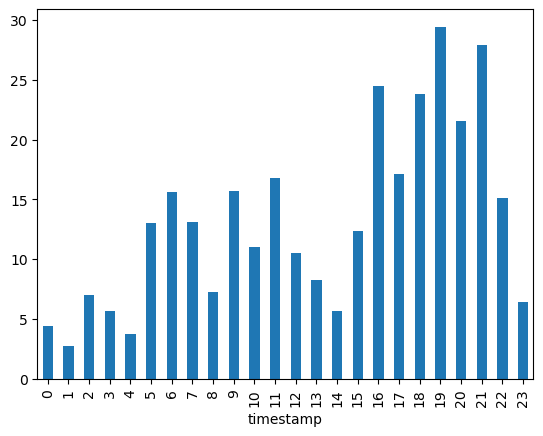

In [132]:
df_n_gd = df_n[df_n['triggered_by'] == 'garden']

((df_n_gd.groupby(df_n_gd.timestamp.dt.hour).count())/ len(df_n_gd.timestamp.dt.date.unique()))['timestamp'].plot.bar(legend=False)

<Axes: xlabel='timestamp'>

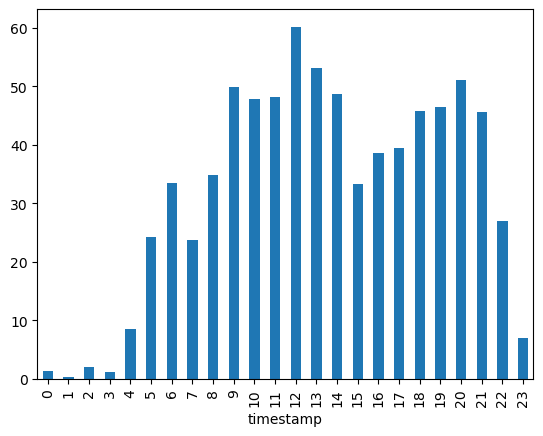

In [133]:
df_n_hw = df_n[df_n['triggered_by'] == 'hallway']

((df_n_hw.groupby(df_n_hw.timestamp.dt.hour).count())/ len(df_n_hw.timestamp.dt.date.unique()))['timestamp'].plot.bar(legend=False)

<Axes: >

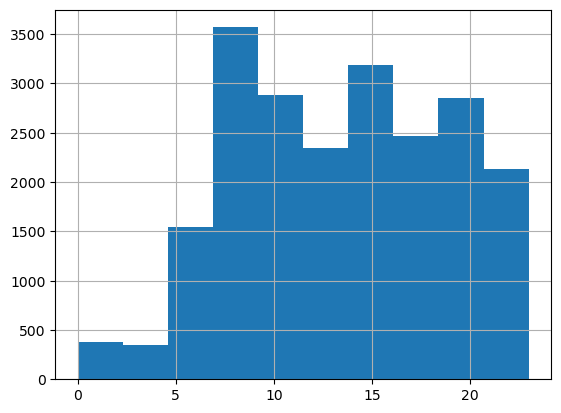

In [152]:
df_n.timestamp.dt.hour.hist()

TypeError: '<' not supported between instances of 'datetime.time' and 'float'

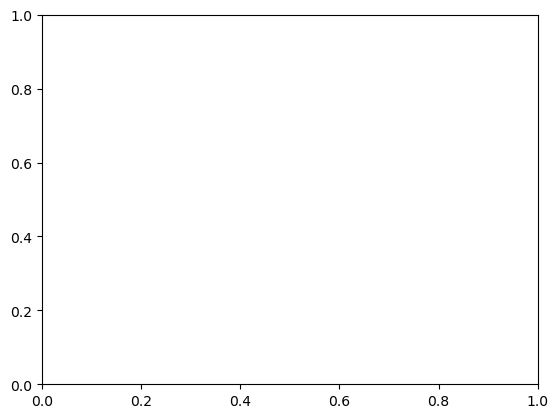

In [141]:
plt.hist(data, bins=10)

In [142]:
data

array([datetime.time(18, 9, 48), datetime.time(18, 10, 24),
       datetime.time(18, 10, 28), ..., datetime.time(11, 13, 36),
       datetime.time(11, 15, 37), datetime.time(11, 15, 38)], dtype=object)

### The idea
Inputs:
- triggered_by (outer_fence/garden/hallway)
- hour
- minutes
- detection ema hallway hashmap (running 5d)
- detection ema outer_fence hashmap (running 5d)
- detection ema hallway hashmap (running 5d)

Outputs:
- Flag 0/1